# Imports, load features and target

In [83]:
import importlib
import utilityFunctions
importlib.reload(utilityFunctions)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<module 'utilityFunctions' from '/workspaces/mlops-fake-news-prediction/utilityFunctions.py'>

In [1]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
import lightgbm as lgb
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score

from utilityFunctions import get_sentiment, test_feature_sets, remove_outliers, evaluate, load_file_s3, upload_to_s3

import pandas as pd
import mlflow
import numpy as np
import itertools
import time
import joblib
import matplotlib.pyplot as plt

from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from hyperopt.pyll.base import scope
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
X_train = load_file_s3('fake-news-prediction', 'datasets/X_train.parquet', 'parquet')
X_val = load_file_s3('fake-news-prediction', 'datasets/X_val.parquet', 'parquet')

y_train = load_file_s3('fake-news-prediction', 'datasets/y_train.csv', 'csv')
y_val = load_file_s3('fake-news-prediction', 'datasets/y_val.csv', 'csv')

In [3]:
# Add new feature sentiment scores
X_train['sentiment'] = X_train['text'].apply(get_sentiment)
X_val['sentiment'] = X_val['text'].apply(get_sentiment)

In [4]:
y_train = y_train.loc[:, 'label']
y_val = y_val.loc[:, 'label']

In [5]:
num_cols = X_train.select_dtypes(include=['number']).columns
cat_cols = X_train.select_dtypes(include=['object']).columns

# Feature Transformation

**Description of the Feature Transformation Code**

When training a model, the choice of features plays a crucial role. In this code, different feature sets are created and tested to find out which combination yields the best results.

The features consist of:
- **Bag-of-Words (BoW)**: A classic method of converting text into a numerical form. It counts how often a word appears in a document.
- **TF-IDF (Term Frequency - Inverse Document Frequency)**: An alternative method that not only considers the frequency of a word but also its relevance across the entire corpus.
- **Numerical Features**: In addition to the text data, the dataset contains numerical columns that describe various properties of the text, such as word count or average word length.

**Four Different Feature Sets**

The code tests four different combinations of features:

BoW Only (bow_only):
- The text column (title_text_clean) is converted into a numerical representation using CountVectorizer().
- All other columns are ignored.

TF-IDF Only (tfidf_only):
- Similar to bow_only, but uses TfidfVectorizer() to weight the importance of words.

BoW + Numerical Features (bow_num):
- The text column is vectorized using CountVectorizer().
- The numerical columns are left unchanged.

TF-IDF + Numerical Features (tfidf_num):
- The text column is vectorized using TfidfVectorizer().
- The numerical columns are also included.

In [6]:
# BoW only
count_vectorizer = CountVectorizer()
X_train_bow = count_vectorizer.fit_transform(X_train['title_text_clean'])
X_val_bow = count_vectorizer.transform(X_val['title_text_clean'])

In [6]:
print(f"X_train_bow Shape: {X_train_bow.shape}")  
print(f"y_train Shape: {y_train.shape}")

X_train_bow Shape: (36840, 173341)
y_train Shape: (36840,)


In [5]:
# TF-IDF only
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train['title_text_clean'])
X_val_tfidf = tfidf_vectorizer.transform(X_val['title_text_clean'])

In [8]:
print(f"X_train_tfidf Shape: {X_train_tfidf.shape}")  
print(f"y_train Shape: {y_train.shape}")

X_train_tfidf Shape: (36840, 173341)
y_train Shape: (36840,)


In [8]:
# from sklearn.compose import ColumnTransformer
# from sklearn.preprocessing import StandardScaler, OneHotEncoder
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.pipeline import Pipeline

# num_cols = X_train.select_dtypes(include=['number'])
# text_col = 'title_text_clean'

# preprocessor = ColumnTransformer([
#     ('num', StandardScaler(), num_cols),
#     ('text', CountVectorizer(), text_col)
# ])

# X_train_pre = preprocessor.fit_transform(X_train)
# X_val_pre = preprocessor.transform(X_val)

# print(X_train.toarray())

In [7]:
# BoW + Numerical Features
# Drop unused columns
X_train_pre = X_train.drop(columns=['text', 'title', 'title_text', 'language'], errors='ignore')
X_val_pre = X_val.drop(columns=['text', 'title', 'title_text', 'language'], errors='ignore')

# define columns to preprocess
num_cols = X_train_pre.select_dtypes(include=['number']).columns.tolist()
text_col = 'title_text_clean'

# Define preprocessor for Bag of words vectorization (Numerical columns remain unchanged)
preprocessor_bow = ColumnTransformer([
    ('text', CountVectorizer(), text_col)
], remainder='passthrough')

# Perform transformation
X_train_bow_num = preprocessor_bow.fit_transform(X_train_pre)
X_val_bow_num = preprocessor_bow.transform(X_val_pre)

In [50]:
print(preprocessor_bow.get_feature_names_out())

['text__00' 'text__000' 'text__0000' ... 'remainder__sentence_count'
 'remainder__special_char_count' 'remainder__sentiment']


In [51]:
print("Train Shape:", X_train_bow.shape)
print("Validation Shape:", X_val_bow.shape)

Train Shape: (36840, 173341)
Validation Shape: (12280, 173341)


In [52]:
print("Train Shape:", X_train_bow_num.shape)
print("Validation Shape:", X_val_bow_num.shape)

Train Shape: (36840, 173350)
Validation Shape: (12280, 173350)


In [8]:
# TF-IDF + Numerical Features
# Define preprocessor for tfidf vectorization (Numerical columns remain unchanged)
preprocessor_tfidf = ColumnTransformer([
    ('text', TfidfVectorizer(), text_col)
], remainder='passthrough')

# Perform transformation
X_train_tfidf_num = preprocessor_tfidf.fit_transform(X_train_pre)
X_val_tfidf_num = preprocessor_tfidf.transform(X_val_pre)

In [11]:
type(X_train_tfidf_num)

scipy.sparse._csr.csr_matrix

In [54]:
print("Train Shape:", X_train_tfidf.shape)
print("Validation Shape:", X_val_tfidf.shape)

Train Shape: (36840, 173341)
Validation Shape: (12280, 173341)


In [55]:
print("Train Shape:", X_train_tfidf_num.shape)
print("Validation Shape:", X_val_tfidf_num.shape)

Train Shape: (36840, 173350)
Validation Shape: (12280, 173350)


In [9]:
feature_sets = {
    "bow_only": X_train_bow,
    "tfidf_only": X_train_tfidf,
    "bow_num": X_train_bow_num,
    "tfidf_num": X_train_tfidf_num
}

validation_sets = {
    "bow_only": X_val_bow,
    "tfidf_only": X_val_tfidf,
    "bow_num": X_val_bow_num,
    "tfidf_num": X_val_tfidf_num
}

# Test different feature sets

## Train  Random Forest

In [87]:
test_feature_sets(RandomForestClassifier(random_state=0, n_jobs=-1), feature_sets, y_train, validation_sets, y_val)

classification report for feature set: bow_only
              precision    recall  f1-score   support

        Real      0.936     0.880     0.907      5414
        Fake      0.910     0.953     0.931      6866

    accuracy                          0.921     12280
   macro avg      0.923     0.916     0.919     12280
weighted avg      0.921     0.921     0.920     12280

classification report for feature set: tfidf_only
              precision    recall  f1-score   support

        Real      0.925     0.890     0.907      5414
        Fake      0.916     0.943     0.929      6866

    accuracy                          0.920     12280
   macro avg      0.920     0.917     0.918     12280
weighted avg      0.920     0.920     0.919     12280

classification report for feature set: bow_num
              precision    recall  f1-score   support

        Real      0.934     0.892     0.913      5414
        Fake      0.918     0.951     0.934      6866

    accuracy                         

## Train XGBoost

In [13]:
feature_sets.keys()

dict_keys(['bow_only', 'tfidf_only', 'bow_num', 'tfidf_num'])

In [14]:
feature_sets = {
    "bow_only": X_train_bow
}

validation_sets = {
    "bow_only": X_val_bow
}

In [15]:
test_feature_sets(XGBClassifier(random_state=0, n_jobs=-1), feature_sets, y_train, validation_sets, y_val)

classification report for feature set: bow_only
              precision    recall  f1-score   support

        Real      0.959     0.972     0.965      5414
        Fake      0.978     0.967     0.972      6866

    accuracy                          0.969     12280
   macro avg      0.968     0.970     0.969     12280
weighted avg      0.969     0.969     0.969     12280



              precision    recall  f1-score   support

        Real      0.959     0.972     0.965      5414
        Fake      0.978     0.967     0.972      6866

    accuracy                          0.969     12280
   macro avg      0.968     0.970     0.969     12280
weighted avg      0.969     0.969     0.969     12280



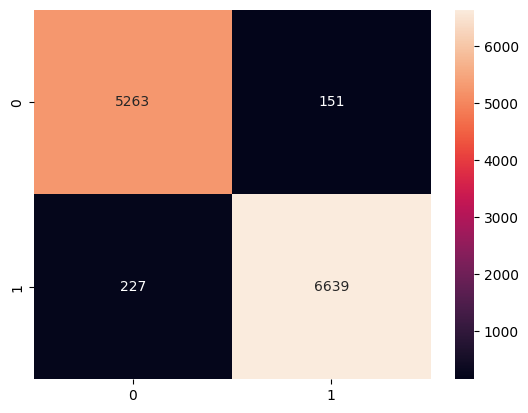

In [10]:
xgb_bow = XGBClassifier(random_state=0, n_jobs=-1)
xgb_bow.fit(X_train_bow, y_train)
y_pred_bow_xgb = xgb_bow.predict(X_val_bow)
evaluate(y_val, y_pred_bow_xgb)

              precision    recall  f1-score   support

        Real      0.964     0.975     0.970      5414
        Fake      0.980     0.971     0.976      6866

    accuracy                          0.973     12280
   macro avg      0.972     0.973     0.973     12280
weighted avg      0.973     0.973     0.973     12280



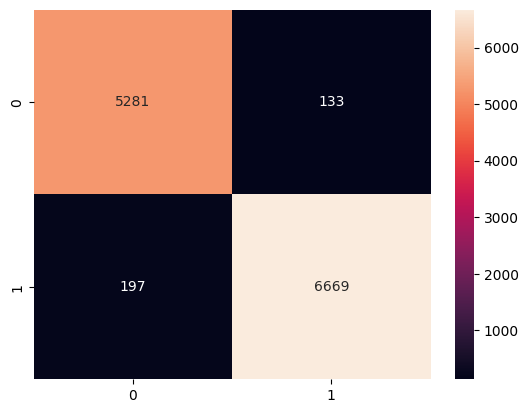

In [11]:
xgb_bow_num = XGBClassifier(random_state=0, n_jobs=-1)
xgb_bow_num.fit(X_train_bow_num, y_train)
y_pred_bow_xgb = xgb_bow_num.predict(X_val_bow_num)
evaluate(y_val, y_pred_bow_xgb)

              precision    recall  f1-score   support

        Real      0.954     0.970     0.962      5414
        Fake      0.976     0.963     0.970      6866

    accuracy                          0.966     12280
   macro avg      0.965     0.967     0.966     12280
weighted avg      0.966     0.966     0.966     12280



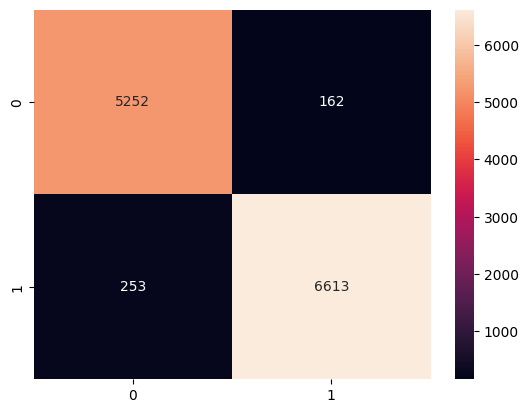

In [9]:
xgb_tfidf = XGBClassifier(random_state=0, n_jobs=-1)
xgb_tfidf.fit(X_train_tfidf, y_train)
y_pred_tfidf_xgb = xgb_tfidf.predict(X_val_tfidf)
evaluate(y_val, y_pred_tfidf_xgb)

In [ ]:
xgb_tfidf_num = XGBClassifier(random_state=0, n_jobs=-1)
xgb_tfidf_num.fit(X_train_tfidf_num, y_train)
y_pred_tfidf_xgb = xgb_tfidf_num.predict(X_val_tfidf_num)
evaluate(y_val, y_pred_tfidf_xgb)

## Train LightGBM

[LightGBM] [Info] Number of positive: 20490, number of negative: 16350
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 6.386917 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 100778
[LightGBM] [Info] Number of data points in the train set: 36840, number of used features: 18452
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.556189 -> initscore=0.225709
[LightGBM] [Info] Start training from score 0.225709


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


              precision    recall  f1-score   support

        Real      0.956     0.972     0.964      5414
        Fake      0.978     0.965     0.971      6866

    accuracy                          0.968     12280
   macro avg      0.967     0.969     0.968     12280
weighted avg      0.968     0.968     0.968     12280



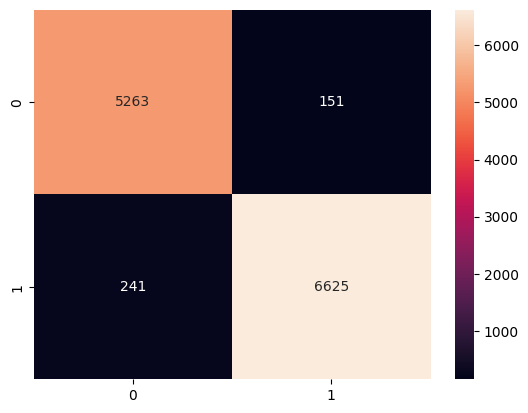

In [13]:
lgb_bow = lgb.LGBMClassifier(random_state=0, n_jobs=-1)
lgb_bow.fit(X_train_bow.astype(np.float32), y_train, feature_name='auto')
y_pred_bow_lgb = lgb_bow.predict(X_val_bow.astype(np.float32))
evaluate(y_val, y_pred_bow_lgb)

[LightGBM] [Info] Number of positive: 20490, number of negative: 16350
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 6.438493 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1171654
[LightGBM] [Info] Number of data points in the train set: 36840, number of used features: 18452
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.556189 -> initscore=0.225709
[LightGBM] [Info] Start training from score 0.225709


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


              precision    recall  f1-score   support

        Real      0.954     0.968     0.961      5414
        Fake      0.975     0.964     0.969      6866

    accuracy                          0.966     12280
   macro avg      0.964     0.966     0.965     12280
weighted avg      0.966     0.966     0.966     12280



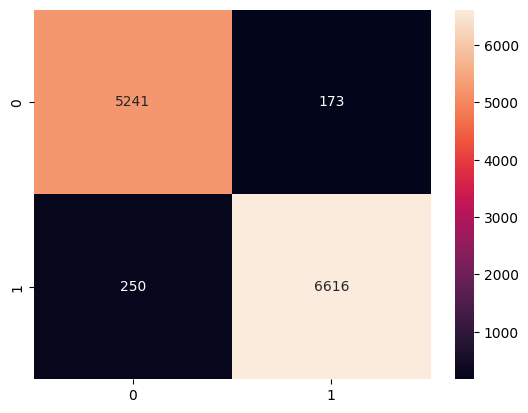

In [16]:
lgb_tfidf = lgb.LGBMClassifier(random_state=0, n_jobs=-1)
lgb_tfidf.fit(X_train_tfidf.astype(np.float32), y_train)
y_pred_tfidf_lgb = lgb_tfidf.predict(X_val_tfidf.astype(np.float32))
evaluate(y_val, y_pred_tfidf_lgb)

## Train LinearSVC

In [8]:
X_train_bow.shape

(36840, 173341)

              precision    recall  f1-score   support

        Real      0.936     0.930     0.933      5414
        Fake      0.945     0.950     0.947      6866

    accuracy                          0.941     12280
   macro avg      0.941     0.940     0.940     12280
weighted avg      0.941     0.941     0.941     12280



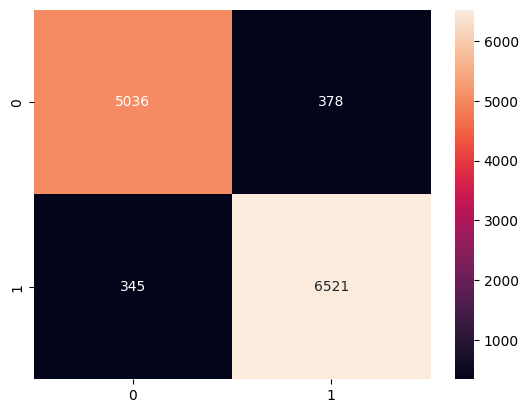

In [14]:
svc_bow = LinearSVC(random_state=0, max_iter=5000)
svc_bow.fit(X_train_bow, y_train)
y_pred_bow_svc = svc_bow.predict(X_val_bow)
evaluate(y_val, y_pred_bow_svc)

              precision    recall  f1-score   support

        Real      0.952     0.950     0.951      5414
        Fake      0.960     0.962     0.961      6866

    accuracy                          0.957     12280
   macro avg      0.956     0.956     0.956     12280
weighted avg      0.957     0.957     0.957     12280



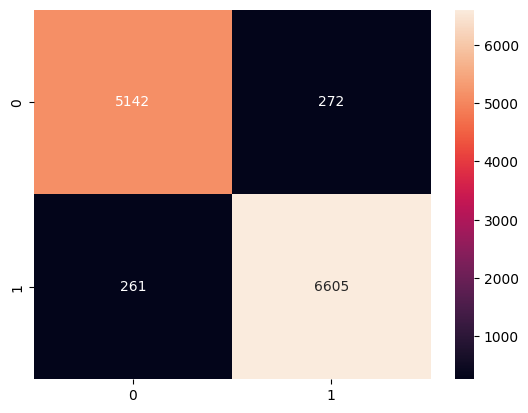

In [10]:
svc_tfidf = LinearSVC(dual=True, random_state=0)
svc_tfidf.fit(X_train_tfidf, y_train)
y_pred_tfidf_svc = svc_tfidf.predict(X_val_tfidf)
evaluate(y_val, y_pred_tfidf_svc)

# Check with and without Outliers

In [14]:
print(len(X_train))
X_train_no, y_train_no = remove_outliers(X_train, y_train, num_cols, threshold=3, iterations=1)
print(len(X_train_no))

36840
0
24701


In [15]:
tfidf_vectorizer = TfidfVectorizer()
X_train_no = tfidf_vectorizer.fit_transform(X_train_no['title_text_clean'])
X_val_no = tfidf_vectorizer.transform(X_val['title_text_clean'])

## RandomForest

              precision    recall  f1-score   support

        Real      0.894     0.878     0.886      5414
        Fake      0.905     0.918     0.911      6866

    accuracy                          0.900     12280
   macro avg      0.900     0.898     0.899     12280
weighted avg      0.900     0.900     0.900     12280



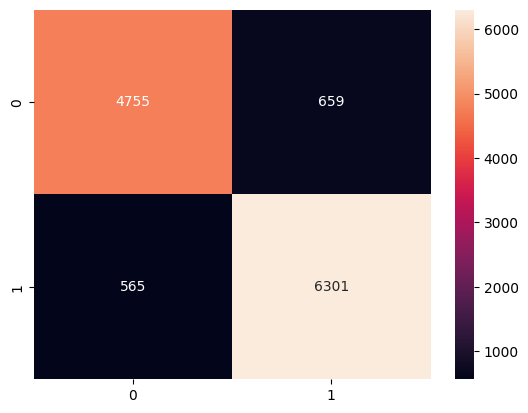

In [17]:
rf_tfidf_no = RandomForestClassifier(random_state=0, n_jobs=-1)
rf_tfidf_no.fit(X_train_no, y_train_no)
y_pred_no = rf_tfidf_no.predict(X_val_no)
evaluate(y_val, y_pred_no)

## XGBoost

              precision    recall  f1-score   support

        Real      0.954     0.960     0.957      5414
        Fake      0.968     0.963     0.966      6866

    accuracy                          0.962     12280
   macro avg      0.961     0.961     0.961     12280
weighted avg      0.962     0.962     0.962     12280



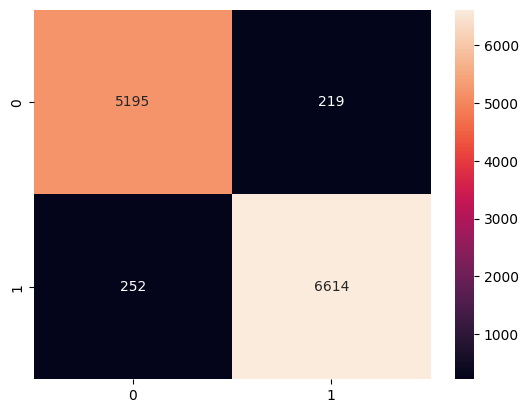

In [19]:
xgb_tfidf_no = XGBClassifier(random_state=0, n_jobs=-1)
xgb_tfidf_no.fit(X_train_no, y_train_no)
y_pred_no = xgb_tfidf_no.predict(X_val_no)
evaluate(y_val, y_pred_no)

## LightGBM

[LightGBM] [Info] Number of positive: 14792, number of negative: 9909
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.879242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 714659
[LightGBM] [Info] Number of data points in the train set: 24701, number of used features: 11754
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.598842 -> initscore=0.400643
[LightGBM] [Info] Start training from score 0.400643
              precision    recall  f1-score   support

        Real      0.953     0.961     0.957      5414
        Fake      0.969     0.963     0.966      6866

    accuracy                          0.962     12280
   macro avg      0.961     0.962     0.962     12280
weighted avg      0.962     0.962     0.962     12280



/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


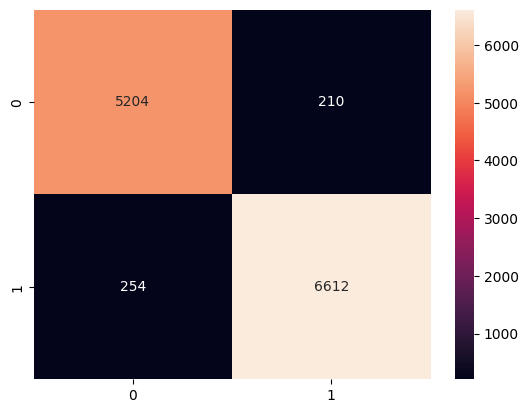

In [20]:
lgb_tfidf_no = lgb.LGBMClassifier(random_state=0, n_jobs=-1)
lgb_tfidf_no.fit(X_train_no.astype(np.float32), y_train_no)
y_pred_no = lgb_tfidf_no.predict(X_val_no.astype(np.float32))
evaluate(y_val, y_pred_no)

## LinearSVC

              precision    recall  f1-score   support

        Real      0.943     0.934     0.939      5414
        Fake      0.948     0.956     0.952      6866

    accuracy                          0.946     12280
   macro avg      0.946     0.945     0.945     12280
weighted avg      0.946     0.946     0.946     12280



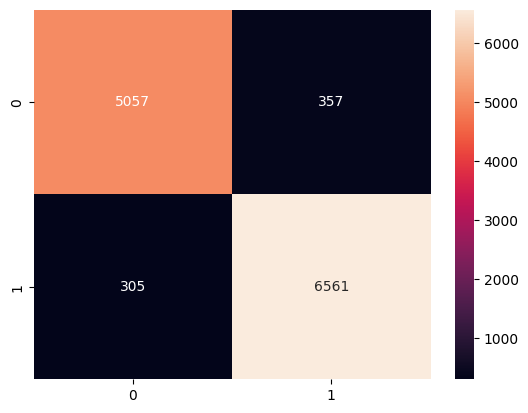

In [21]:
svc_tfidf_no = LinearSVC(dual=True, random_state=0)
svc_tfidf_no.fit(X_train_no, y_train_no)
y_pred_no = svc_tfidf_no.predict(X_val_no)
evaluate(y_val, y_pred_no)

# Baseline model

              precision    recall  f1-score   support

        Real       0.94      0.88      0.91      5414
        Fake       0.91      0.95      0.93      6866

    accuracy                           0.92     12280
   macro avg       0.92      0.92      0.92     12280
weighted avg       0.92      0.92      0.92     12280



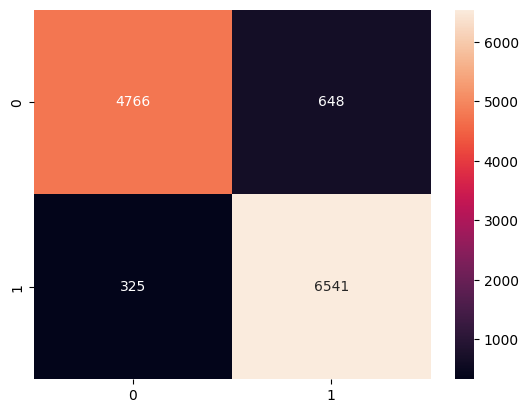

In [21]:
rf_baseline = RandomForestClassifier(random_state=0)
rf_baseline.fit(X_train_bow, y_train)
y_pred_baseline = rf_baseline.predict(X_val_bow)
evaluate(y_val, y_pred_baseline)

In [22]:
rf_baseline.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}

In [34]:
features = ['text_word_count', 'title_word_count', 'text_unique_words', 
            'text_char_count', 'title_char_count', 'avg_word_length', 
            'sentence_count', 'special_char_count']

# test feature combinations
cv = KFold(n_splits=4, shuffle=True, random_state=0)
results_xgb = []
for i in range(1, len(features) + 1):  # Variierende Anzahl an Features
    for subset in itertools.combinations(features, i):

        X = X_train[list(subset)]
        y = y_train
    
        grid_search = GridSearchCV(
            estimator=XGBClassifier(learning_rate=0.1, 
                                    max_depth=5,
                                    subsample=0.7,
                                    colsample_bytree=0.8,
                                    random_state=0),
                param_grid={'n_estimators': [150]},
                scoring='accuracy',
                n_jobs=-1,
                return_train_score=True,
                cv=cv
        ).fit(X, y)

        result = grid_search.cv_results_
        result['f_combination'] = list(subset)
        results_xgb.append(result)

In [35]:
results_f_selection_xgb = pd.DataFrame(results_xgb)

In [36]:
upload_to_s3(results_f_selection_rf, 'fake-news-prediction', "datasets/results_f_selection_xgb.parquet")

File saved as datasets/results_f_selection_xgb.parquet in fake-news-prediction.


In [24]:
df_f_selection_xgb = load_file_s3('fake-news-prediction', "datasets/results_f_selection_xgb.parquet", 'parquet')

In [25]:
df_f_selection_xgb[['mean_fit_time', 'mean_score_time', 'mean_test_score', 'mean_train_score', 'f_combination']].sort_values(by='mean_test_score', ascending=False).head(10)

mean_fit_time        mean_score_time       mean_test_score  \
253   [3.566823184490204]  [0.09749019145965576]  [0.7855320304017372]   
251   [3.692900240421295]  [0.09576010704040527]  [0.7850705754614549]   
232   [3.370055675506592]  [0.09483373165130615]  [0.7838762214983713]   
244  [3.6123124957084656]  [0.09962856769561768]  [0.7837947882736156]   
254   [4.391331970691681]  [0.12537449598312378]   [0.783441910966341]   
245   [3.921709716320038]  [0.09947854280471802]  [0.7831976112920739]   
252   [3.910745680332184]  [0.08860158920288086]  [0.7829804560260587]   
250   [3.380977511405945]  [0.10192924737930298]   [0.782899022801303]   
240  [3.8965378403663635]  [0.09487831592559814]  [0.7828718783930511]   
237  [3.6244653463363647]  [0.09370863437652588]  [0.7827361563517916]   

         mean_train_score                                      f_combination  
253  [0.8070304017372422]  [title_word_count, text_unique_words, text_cha...  
251  [0.8070846905537459]  [text_word_count, title_word_count, text_char_...  
232  [0.8073832790445168]  [text_word_count, title_word_count, title_char...  
244  [0.8064603691639523]  [title_word_count, text_char_count, title_char...  
254  [0.8068675352877308]  [text_word_count, title_word_count, text_uniqu...  
245  [0.8055736518277236]  [text_unique_words, text_char_count, title_cha...  
252  [0.8051393412956931]  [text_word_count, text_unique_words, text_char...  
250  [0.8061074918566775]  [text_word_count, title_word_count, text_uniqu...  
240  [0.8062794064422729]  [title_word_count, text_unique_words, text_cha...  
237  [0.8054650741947158]  [text_word_count, text_unique_words, title_cha...

In [26]:
df_f_selection_xgb.loc[253, 'f_combination']

array(['title_word_count', 'text_unique_words', 'text_char_count',
       'title_char_count', 'avg_word_length', 'sentence_count',
       'special_char_count'], dtype=object)

              precision    recall  f1-score   support

        Real      0.802     0.711     0.754      5414
        Fake      0.791     0.862     0.825      6866

    accuracy                          0.795     12280
   macro avg      0.797     0.786     0.789     12280
weighted avg      0.796     0.795     0.793     12280



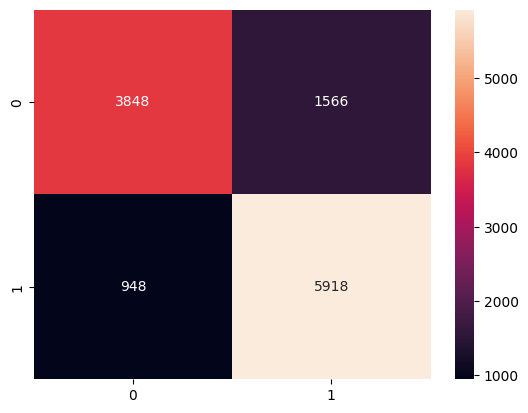

In [27]:
xgb = XGBClassifier(learning_rate=0.1,
                    n_estimators=150,
                    max_depth=5,
                    subsample=0.7,
                    colsample_bytree=0.8,
                    random_state=0)

xgb.fit(X_train[['title_word_count', 'text_unique_words', 'text_char_count',
       'title_char_count', 'avg_word_length', 'sentence_count',
       'special_char_count']], y_train)
y_pred_xgb = xgb.predict(X_val[['title_word_count', 'text_unique_words', 'text_char_count',
       'title_char_count', 'avg_word_length', 'sentence_count',
       'special_char_count']])
evaluate(y_val, y_pred_xgb)

In [ ]:
# Trainingszeit messen
# start_train = time.time()
# model.fit(X_train, y_train)
# end_train = time.time()
# training_time = end_train - start_train

# Inference-Zeit messen (Vorhersage auf Test-Set)
# start_infer = time.time()
# model.predict(X_test)
# end_infer = time.time()
# inference_time = end_infer - start_infer

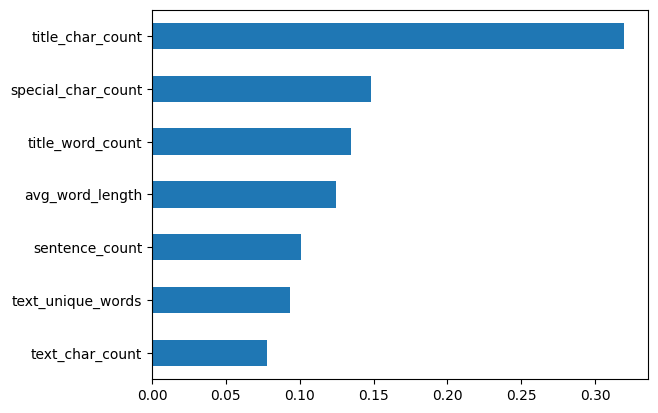

In [56]:
pd.DataFrame(data=xgb.feature_importances_, index=xgb.feature_names_in_).sort_values(by=0, ascending=True).plot(kind='barh', legend=False);

Train XGBoost with different feature set

              precision    recall  f1-score   support

        Real      0.799     0.712     0.753      5414
        Fake      0.791     0.859     0.823      6866

    accuracy                          0.794     12280
   macro avg      0.795     0.785     0.788     12280
weighted avg      0.794     0.794     0.792     12280



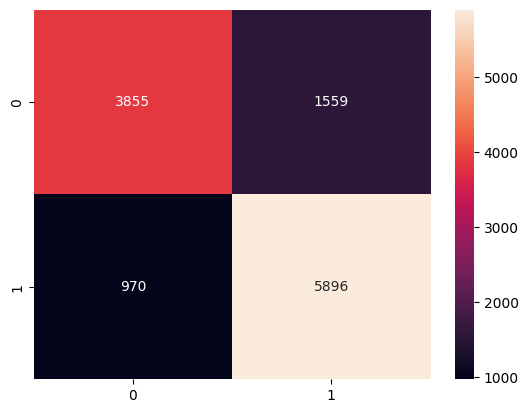

In [23]:
xgb = XGBClassifier(learning_rate=0.1,
                    n_estimators=150,
                    max_depth=5,
                    subsample=0.7,
                    colsample_bytree=0.8,
                    random_state=0)

xgb.fit(X_train[num_cols], y_train)
y_pred_xgb = xgb.predict(X_val[num_cols])
evaluate(y_val, y_pred_xgb)

# Feature Selection

## Train Random Forest with different feature set

              precision    recall  f1-score   support

        Real       0.79      0.69      0.74      5414
        Fake       0.78      0.86      0.82      6866

    accuracy                           0.78     12280
   macro avg       0.78      0.77      0.78     12280
weighted avg       0.78      0.78      0.78     12280



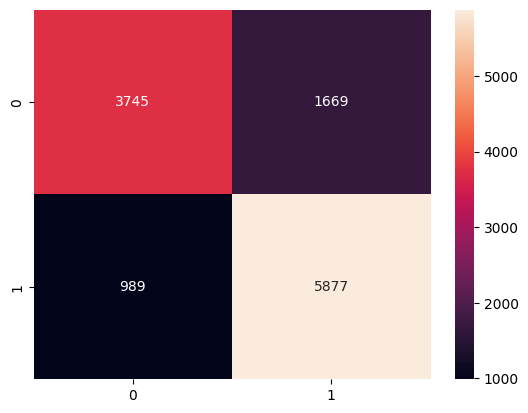

In [25]:
rf = RandomForestClassifier(min_samples_leaf=10, max_depth=10, n_estimators=100, random_state=0, n_jobs=-1)
rf.fit(X_train[num_cols], y_train)
y_pred_rf = rf.predict(X_val[num_cols])
evaluate(y_val, y_pred_rf)

Plot Feature Importances for Random Forest

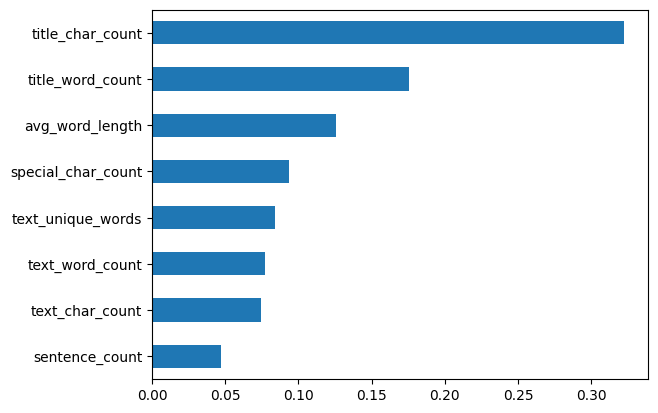

In [29]:
pd.DataFrame(data=rf.feature_importances_, index=rf.feature_names_in_).sort_values(by=0, ascending=True).plot(kind='barh', legend=False);

Train Random Forest with different feature set

In [18]:
features = ['text_word_count', 'title_word_count', 'text_unique_words', 
            'text_char_count', 'title_char_count', 'avg_word_length', 
            'sentence_count', 'special_char_count']

# test feature combinations
cv = KFold(n_splits=4, shuffle=True, random_state=0)
results = []
for i in range(1, len(features) + 1):  # Variierende Anzahl an Features
    for subset in itertools.combinations(features, i):

        X = X_train[list(subset)]
        y = y_train
    
        grid_search = GridSearchCV(
            estimator=RandomForestClassifier(min_samples_leaf=10, max_depth=10, random_state=0, n_jobs=-1),
                param_grid={'n_estimators': [100]},
                scoring='accuracy',
                n_jobs=2,
                return_train_score=True,
                cv=cv
        ).fit(X, y)

        result = grid_search.cv_results_
        result['f_combination'] = subset
        results.append(result)

In [19]:
results_f_selection_rf = pd.DataFrame(results)

In [21]:
upload_to_s3(results_f_selection_rf, 'fake-news-prediction', "datasets/results_f_selection_rf.parquet")

File saved as datasets/results_f_selection_rf.parquet in fake-news-prediction.


In [22]:
df_f_selection_rf = load_file_s3('fake-news-prediction', "datasets/results_f_selection_rf.parquet", 'parquet')

In [23]:
df_f_selection_rf[['mean_fit_time', 'mean_score_time', 'mean_test_score', 'mean_train_score', 'f_combination']].sort_values(by='mean_test_score', ascending=False).head(10)

mean_fit_time        mean_score_time       mean_test_score  \
253   [3.566823184490204]  [0.09749019145965576]  [0.7855320304017372]   
251   [3.692900240421295]  [0.09576010704040527]  [0.7850705754614549]   
232   [3.370055675506592]  [0.09483373165130615]  [0.7838762214983713]   
244  [3.6123124957084656]  [0.09962856769561768]  [0.7837947882736156]   
254   [4.391331970691681]  [0.12537449598312378]   [0.783441910966341]   
245   [3.921709716320038]  [0.09947854280471802]  [0.7831976112920739]   
252   [3.910745680332184]  [0.08860158920288086]  [0.7829804560260587]   
250   [3.380977511405945]  [0.10192924737930298]   [0.782899022801303]   
240  [3.8965378403663635]  [0.09487831592559814]  [0.7828718783930511]   
237  [3.6244653463363647]  [0.09370863437652588]  [0.7827361563517916]   

         mean_train_score                                      f_combination  
253  [0.8070304017372422]  [title_word_count, text_unique_words, text_cha...  
251  [0.8070846905537459]  [text_word_count, title_word_count, text_char_...  
232  [0.8073832790445168]  [text_word_count, title_word_count, title_char...  
244  [0.8064603691639523]  [title_word_count, text_char_count, title_char...  
254  [0.8068675352877308]  [text_word_count, title_word_count, text_uniqu...  
245  [0.8055736518277236]  [text_unique_words, text_char_count, title_cha...  
252  [0.8051393412956931]  [text_word_count, text_unique_words, text_char...  
250  [0.8061074918566775]  [text_word_count, title_word_count, text_uniqu...  
240  [0.8062794064422729]  [title_word_count, text_unique_words, text_cha...  
237  [0.8054650741947158]  [text_word_count, text_unique_words, title_cha...

In [49]:
df_f_selection_rf.loc[253, 'f_combination']

array(['title_word_count', 'text_unique_words', 'text_char_count',
       'title_char_count', 'avg_word_length', 'sentence_count',
       'special_char_count'], dtype=object)

              precision    recall  f1-score   support

        Real       0.79      0.70      0.74      5414
        Fake       0.78      0.85      0.82      6866

    accuracy                           0.78     12280
   macro avg       0.78      0.77      0.78     12280
weighted avg       0.78      0.78      0.78     12280



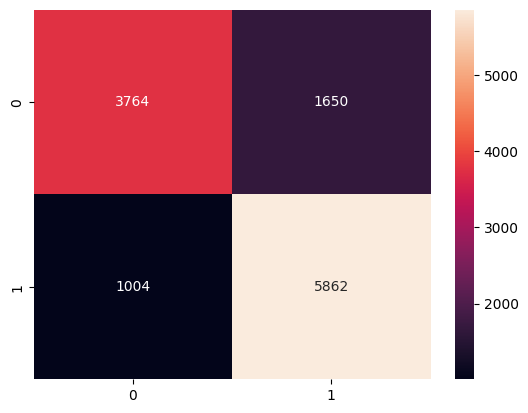

In [51]:
rf = RandomForestClassifier(min_samples_leaf=10, max_depth=10, n_estimators=100, random_state=0, n_jobs=-1)
rf.fit(X_train[['title_word_count', 'text_unique_words', 'text_char_count',
       'title_char_count', 'avg_word_length', 'sentence_count',
       'special_char_count']], y_train)
y_pred_rf = rf.predict(X_val[['title_word_count', 'text_unique_words', 'text_char_count',
       'title_char_count', 'avg_word_length', 'sentence_count',
       'special_char_count']])
evaluate(y_val, y_pred_rf)

## Train XGBoost with different feature set

# Experiment Tracking with MLflow

In [7]:
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("mlflow-fake-news")

<Experiment: artifact_location='s3://fake-news-prediction/1', creation_time=1742206809372, experiment_id='1', last_update_time=1742206809372, lifecycle_stage='active', name='mlflow-fake-news', tags={}>

In [22]:
def run_optimization(X_train, y_train, X_val, y_val, model_name, search_space, num_trials, name_train_data, name_val_data):

    def objective(params):

        with mlflow.start_run():
            mlflow.set_tag("model", model_name)
            mlflow.log_params(params)
            mlflow.log_param("train-data", name_train_data)
            mlflow.log_param("valid-data", name_val_data)
            mlflow.log_param("model_name", model_name)

            # Modell ausw√§hlen
            if model_name == "RandomForest":
                model = RandomForestClassifier(**params)
            elif model_name == "XGBoost":
                model = XGBClassifier(**params)
            elif model_name == "LinearSVC":
                model = LinearSVC(**params)
            elif model_name == "LightGBM":
                model = lgb.LGBMClassifier(**params, objective='binary')
            # elif model_name == "ExtraTrees":
                # model = ExtraTreesRegressor(**params)
            else:
                raise ValueError(f"Unknown model: {model_name}")

            # measure training time
            start_time = time.time()
        
            model.fit(X_train, y_train)

            end_time = time.time()
            training_time = end_time - start_time
            mlflow.log_metric("training_time", training_time)

            # Prediction for training and validation-set
            y_train_pred = model.predict(X_train)

            # measure inference time
            start_inference_time = time.time()
            
            y_val_pred = model.predict(X_val)

            end_inference_time = time.time()
            inference_time = end_inference_time - start_inference_time
            mlflow.log_metric("inference_time", inference_time)
            
            # Metrics for training set
            train_accuracy = accuracy_score(y_train, y_train_pred)
            train_precision = precision_score(y_train, y_train_pred)
            train_recall = recall_score(y_train, y_train_pred)
            
            # Metrics for test set
            val_accuracy = accuracy_score(y_val, y_val_pred)
            val_precision = precision_score(y_val, y_val_pred)
            val_recall = recall_score(y_val, y_val_pred)

            mlflow.log_metric("train_accuracy", train_accuracy)
            mlflow.log_metric("train_precision", train_precision)
            mlflow.log_metric("train_recall", train_recall)

            mlflow.log_metric("accuracy", val_accuracy)
            mlflow.log_metric("precision", val_precision)
            mlflow.log_metric("recall", val_recall)

        return {'loss': val_accuracy, 'status': STATUS_OK}

    rstate = np.random.default_rng(42)  # for reproducible results
    fmin(
        fn=objective,
        space=search_space,
        algo=tpe.suggest,
        max_evals=num_trials,
        trials=Trials(),
        rstate=rstate
    )

## Experiment Tracking Random Forest

In [12]:
search_space_rf = {
        'max_depth': scope.int(hp.quniform('max_depth', 50, 100, 1)),
        'n_estimators': scope.int(hp.quniform('n_estimators', 150, 250, 1)),
        'min_samples_split': scope.int(hp.quniform('min_samples_split', 2, 20, 1)),
        'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 1, 4, 1)),
        'random_state': 42
    }

run_optimization(X_train_tfidf, y_train,X_val_tfidf, y_val, classifier="RandomForest", search_space=search_space_rf, num_trials=50)

üèÉ View run rogue-flea-147 at: http://127.0.0.1:5000/#/experiments/1/runs/c7f70d80b3914fba92e6404901714a7d

üß™ View experiment at: http://127.0.0.1:5000/#/experiments/1

üèÉ View run legendary-robin-28 at: http://127.0.0.1:5000/#/experiments/1/runs/c9752458362c4366996378e80bdeb03e

üß™ View experiment at: http://127.0.0.1:5000/#/experiments/1                      

üèÉ View run chill-bug-755 at: http://127.0.0.1:5000/#/experiments/1/runs/63cdfeb64cc94061b817921c3ce823ea

üß™ View experiment at: http://127.0.0.1:5000/#/experiments/1                    

üèÉ View run traveling-wasp-790 at: http://127.0.0.1:5000/#/experiments/1/runs/a76a680468ed413eb3c18cf1694e3ced

üß™ View experiment at: http://127.0.0.1:5000/#/experiments/1                    

üèÉ View run crawling-foal-357 at: http://127.0.0.1:5000/#/experiments/1/runs/f8e0e931853c4f99b21e950b70fcbfa0

üß™ View experiment at: http://127.0.0.1:5000/#/experiments/1                      

üèÉ View run unruly-ox-896 at: http

## Experiment Tracking XGBoost

In [9]:
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
}

search_space_xgb = {
    "max_depth": scope.int(hp.quniform("max_depth", 4, 6, 1)),  # Maximaler Wert f√ºr max_depth reduziert
    "learning_rate": hp.loguniform("learning_rate", -3, -1),  # Kleinerer Bereich f√ºr learning_rate
    "reg_alpha": hp.loguniform("reg_alpha", -5, 0),  # Reduzierter Bereich f√ºr reg_alpha
    "reg_lambda": hp.loguniform("reg_lambda", -6, -2),  # Reduzierter Bereich f√ºr reg_lambda
    "objective": "binary:logistic",  # Klassifikationsziel
    "random_state": 42
}

search_space_xgb = {
    'max_depth': scope.int(hp.quniform("max_depth", 3, 6, 1)),  # Begrenze max_depth
    'n_estimators': scope.int(hp.quniform("n_estimators", 50, 200, 50)),  # Variabel statt fix
    'learning_rate': hp.loguniform("learning_rate", np.log(0.01), np.log(0.3)),  # Falls du es optimieren willst
    'tree_method': 'hist',  # Nutzt effizientere Berechnung
    'seed': 0
}

In [24]:
search_space_xgb = {
    'max_depth': scope.int(hp.quniform("max_depth", 3, 12, 1)),  # Begrenze max_depth
    'n_estimators': scope.int(hp.quniform('n_estimators', 50, 150, 1)),  # Variabel statt fix
    'learning_rate': hp.loguniform("learning_rate", np.log(0.01), np.log(0.3)),  # Falls du es optimieren willst
    'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
    'reg_lambda' : hp.uniform('reg_lambda', 0,1),
    # 'tree_method': 'hist',  # Nutzt effizientere Berechnung
    'seed': 0
}

run_optimization(X_train_bow, y_train, X_val_bow, y_val, model_name='XGBoost', search_space=search_space_xgb, num_trials=10, name_train_data='X_train_bow', name_val_data='X_val_bow')

üèÉ View run powerful-finch-343 at: http://127.0.0.1:5000/#/experiments/1/runs/b83542d9e550435284127baa4826ea67                                                 

üß™ View experiment at: http://127.0.0.1:5000/#/experiments/1                                                                                                   

üèÉ View run loud-shark-273 at: http://127.0.0.1:5000/#/experiments/1/runs/e741fe9062a04fb0a3e610bab1d48f45                                                     

üß™ View experiment at: http://127.0.0.1:5000/#/experiments/1                                                                                                   

üèÉ View run rogue-colt-453 at: http://127.0.0.1:5000/#/experiments/1/runs/a99e13e7b25a47a8946c6be33176804c                                                     

üß™ View experiment at: http://127.0.0.1:5000/#/experiments/1                                                                                                   

üèÉ View run gentle-y

In [8]:
def objective(params, X_train_tfidf, y_train, X_val_tfidf, y_val):
    try:
        # Create DMatrix
        train = xgb.DMatrix(X_train_tfidf, label=y_train)
        valid = xgb.DMatrix(X_val_tfidf, label=y_val)

        #with mlflow.start_run():
            #mlflow.set_tag("model", "xgboost")
            #mlflow.log_param("model_name", "xgboost")
            #mlflow.log_params(params)

            # Train
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=25,  # Weniger Boost-Runden
            evals=[(valid, 'validation')],
            early_stopping_rounds=20
        )

        # Prediction
        y_pred_prob = booster.predict(valid)

        y_pred = (y_pred_prob > 0.5).astype(int)

        # Calculate metrics
        accuracy = accuracy_score(y_val, y_pred)
        precision = precision_score(y_val, y_pred)
        recall = recall_score(y_val, y_pred)

        print(f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}")

            #mlflow.log_metric("accuracy", accuracy)
            #mlflow.log_metric("precision", precision)
            #mlflow.log_metric("recall", recall)

        return {'loss': accuracy, 'status': STATUS_OK}

    except Exception as e:
        print(f"Error occurred during training or evaluation: {e}")
        return {'loss': float('inf'), 'status': STATUS_OK}

# Define search space for`hyperopt`
search_space_xgb = {
    "max_depth": scope.int(hp.quniform("max_depth", 4, 6, 1)),  # Maximaler Wert f√ºr max_depth reduziert
    "learning_rate": hp.loguniform("learning_rate", -3, -1),  # Kleinerer Bereich f√ºr learning_rate
    "reg_alpha": hp.loguniform("reg_alpha", -5, 0),  # Reduzierter Bereich f√ºr reg_alpha
    "reg_lambda": hp.loguniform("reg_lambda", -6, -2),  # Reduzierter Bereich f√ºr reg_lambda
    "objective": "binary:logistic",  # Klassifikationsziel
    "random_state": 42
}

# √úbergebe deine Trainingsdaten an die `objective`-Funktion
# rstate = np.random.default_rng(42)
best_result = fmin(
    fn=lambda params: objective(params, X_train_tfidf, y_train, X_val_tfidf, y_val),
    space=search_space_xgb,
    algo=tpe.suggest,
    max_evals=25,
    trials=Trials()
)


[0]	validation-logloss:0.55834                        
[1]	validation-logloss:0.47412                        
[2]	validation-logloss:0.41195                        
[3]	validation-logloss:0.36646                        
[4]	validation-logloss:0.33238                        
[5]	validation-logloss:0.30420                        
[6]	validation-logloss:0.28353                        
[7]	validation-logloss:0.26669                        
[8]	validation-logloss:0.25274                        
[9]	validation-logloss:0.24076                        
[10]	validation-logloss:0.23030                       
[11]	validation-logloss:0.22098                       
[12]	validation-logloss:0.21327                       
[13]	validation-logloss:0.20632                       
[14]	validation-logloss:0.19935                       
[15]	validation-logloss:0.19430                       
[16]	validation-logloss:0.18997                       
[17]	validation-logloss:0.18418                       
[18]	valid

: 

## Experiment Tracking LightGMB

In [18]:
search_space_lgbm = {
    # 'num_leaves': scope.int(hp.quniform('num_leaves', 20, 150, 1)),  
    'max_depth': scope.int(hp.quniform('max_depth', 4, 15, 1)),  
    'learning_rate': hp.loguniform('learning_rate', -5, 0),  # log-uniform f√ºr feine Abstufungen
    'n_estimators': scope.int(hp.quniform('n_estimators', 50, 150, 1)),  
    # 'min_child_samples': scope.int(hp.quniform('min_child_samples', 5, 50, 1)),  
    'subsample': hp.uniform('subsample', 0.5, 1.0),  
    'colsample_bytree': hp.uniform('colsample_bytree', 0.7, 1.0),  
    # 'reg_alpha': hp.loguniform('reg_alpha', -5, 1),  
    # 'reg_lambda': hp.loguniform('reg_lambda', -5, 1),  
    'seed': 0
}

run_optimization(X_train_bow.astype(np.float32), y_train, X_val_bow.astype(np.float32), y_val, model_name='LightGBM', search_space=search_space_lgbm, num_trials=15)

[LightGBM] [Info] Number of positive: 20490, number of negative: 16350                                                                                         
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 6.136402 seconds.                                                        
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 100778                                                                                                                            
[LightGBM] [Info] Number of data points in the train set: 36840, number of used features: 18452                                                                
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.556189 -> initscore=0.225709                                                                                 
[LightGBM] [Info] Start training from score 0.225709                          

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



üèÉ View run funny-shark-368 at: http://127.0.0.1:5000/#/experiments/1/runs/9daa27825e9d41188f55886bc534b527                                                    

üß™ View experiment at: http://127.0.0.1:5000/#/experiments/1                                                                                                   

[LightGBM] [Info] Number of positive: 20490, number of negative: 16350                                                                                         
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 5.840729 seconds.                                                        
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 100778                                                                                                                            
[LightGBM] [Info] Number of data points in the train set: 36840, number 

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



üèÉ View run burly-skunk-874 at: http://127.0.0.1:5000/#/experiments/1/runs/1d01ef7c00194d5695a616010d58727f                                                    

üß™ View experiment at: http://127.0.0.1:5000/#/experiments/1                                                                                                   

[LightGBM] [Info] Number of positive: 20490, number of negative: 16350                                                                                         
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 5.528587 seconds.                                                        
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 100778                                                                                                                            
[LightGBM] [Info] Number of data points in the train set: 36840, number 

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



üèÉ View run redolent-snipe-941 at: http://127.0.0.1:5000/#/experiments/1/runs/66915378e2574463b31c8d5eaed53982                                                 

üß™ View experiment at: http://127.0.0.1:5000/#/experiments/1                                                                                                   

[LightGBM] [Info] Number of positive: 20490, number of negative: 16350                                                                                         
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 5.716250 seconds.                                                        
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 100778                                                                                                                            
[LightGBM] [Info] Number of data points in the train set: 36840, number 

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



üèÉ View run mysterious-cub-666 at: http://127.0.0.1:5000/#/experiments/1/runs/3658d3a9e82045f88bd86fa52ac6cdf6                                                 

üß™ View experiment at: http://127.0.0.1:5000/#/experiments/1                                                                                                   

[LightGBM] [Info] Number of positive: 20490, number of negative: 16350                                                                                         
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 5.795150 seconds.                                                        
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 100778                                                                                                                            
[LightGBM] [Info] Number of data points in the train set: 36840, number 

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



üèÉ View run enchanting-roo-115 at: http://127.0.0.1:5000/#/experiments/1/runs/72893830ca2844e8af6afa5f90d87c00                                                 

üß™ View experiment at: http://127.0.0.1:5000/#/experiments/1                                                                                                   

[LightGBM] [Info] Number of positive: 20490, number of negative: 16350                                                                                         
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 6.211218 seconds.                                                        
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 100778                                                                                                                            
[LightGBM] [Info] Number of data points in the train set: 36840, number 

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



üèÉ View run bouncy-tern-573 at: http://127.0.0.1:5000/#/experiments/1/runs/6fe6764259324797aa1ece8990f6cd15                                                    

üß™ View experiment at: http://127.0.0.1:5000/#/experiments/1                                                                                                   

[LightGBM] [Info] Number of positive: 20490, number of negative: 16350                                                                                         
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 6.097458 seconds.                                                        
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 100778                                                                                                                            
[LightGBM] [Info] Number of data points in the train set: 36840, number 

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



üèÉ View run delicate-sow-787 at: http://127.0.0.1:5000/#/experiments/1/runs/c68ae51901074ed7a21cbf131a127380                                                   

üß™ View experiment at: http://127.0.0.1:5000/#/experiments/1                                                                                                   

[LightGBM] [Info] Number of positive: 20490, number of negative: 16350                                                                                         
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 6.191686 seconds.                                                        
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 100778                                                                                                                            
[LightGBM] [Info] Number of data points in the train set: 36840, number 

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



üèÉ View run useful-fowl-131 at: http://127.0.0.1:5000/#/experiments/1/runs/073d15a9c42c4d4bb4903d56cc75c610                                                    

üß™ View experiment at: http://127.0.0.1:5000/#/experiments/1                                                                                                   

[LightGBM] [Info] Number of positive: 20490, number of negative: 16350                                                                                         
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 5.646666 seconds.                                                        
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 100778                                                                                                                            
[LightGBM] [Info] Number of data points in the train set: 36840, number 

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



üèÉ View run monumental-snipe-974 at: http://127.0.0.1:5000/#/experiments/1/runs/a01c151308b943c3b6f1675c34b4cb3c                                               

üß™ View experiment at: http://127.0.0.1:5000/#/experiments/1                                                                                                   

[LightGBM] [Info] Number of positive: 20490, number of negative: 16350                                                                                         
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 5.629553 seconds.                                                        
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 100778                                                                                                                            
[LightGBM] [Info] Number of data points in the train set: 36840, number 

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



üèÉ View run fun-auk-737 at: http://127.0.0.1:5000/#/experiments/1/runs/1e9a9acbc3fe49e0bedc4b5a430e36eb                                                        

üß™ View experiment at: http://127.0.0.1:5000/#/experiments/1                                                                                                   

[LightGBM] [Info] Number of positive: 20490, number of negative: 16350                                                                                         
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 5.648353 seconds.                                                        
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 100778                                                                                                                            
[LightGBM] [Info] Number of data points in the train set: 36840, number 

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



üèÉ View run overjoyed-fowl-873 at: http://127.0.0.1:5000/#/experiments/1/runs/9ae4fb41fb85432fad25e25ac4dc763a                                                 

üß™ View experiment at: http://127.0.0.1:5000/#/experiments/1                                                                                                   

[LightGBM] [Info] Number of positive: 20490, number of negative: 16350                                                                                         
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 6.102642 seconds.                                                        
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 100778                                                                                                                            
[LightGBM] [Info] Number of data points in the train set: 36840, number 

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



üèÉ View run treasured-chimp-568 at: http://127.0.0.1:5000/#/experiments/1/runs/d1d39b3cee94419f8b7ccd2e8ebe6672                                                

üß™ View experiment at: http://127.0.0.1:5000/#/experiments/1                                                                                                   

[LightGBM] [Info] Number of positive: 20490, number of negative: 16350                                                                                         
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 5.575310 seconds.                                                        
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 100778                                                                                                                            
[LightGBM] [Info] Number of data points in the train set: 36840, number 

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



üèÉ View run stylish-wren-931 at: http://127.0.0.1:5000/#/experiments/1/runs/2fbb339cdf9a423ca54c9b534f28575e                                                   

üß™ View experiment at: http://127.0.0.1:5000/#/experiments/1                                                                                                   

[LightGBM] [Info] Number of positive: 20490, number of negative: 16350                                                                                         
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 6.144505 seconds.                                                        
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 100778                                                                                                                            
[LightGBM] [Info] Number of data points in the train set: 36840, number 

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



üèÉ View run crawling-vole-20 at: http://127.0.0.1:5000/#/experiments/1/runs/97551958a23b43f6973a5db91fb76580                                                   

üß™ View experiment at: http://127.0.0.1:5000/#/experiments/1                                                                                                   

[LightGBM] [Info] Number of positive: 20490, number of negative: 16350                                                                                         
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 5.794463 seconds.                                                        
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 100778                                                                                                                            
[LightGBM] [Info] Number of data points in the train set: 36840, number 

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



üèÉ View run clean-bat-942 at: http://127.0.0.1:5000/#/experiments/1/runs/c4b62c00f529437892eead9d248d0061                                                      

üß™ View experiment at: http://127.0.0.1:5000/#/experiments/1                                                                                                   

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 15/15 [05:35<00:00, 22.36s/trial, best loss: 0.9400651465798046]


## Experiment Tracking SVM

In [11]:
search_space_svc = {
    "C": hp.loguniform("C", np.log(0.01), np.log(10)),
    "class_weight": hp.choice("class_weight", [None, "balanced"]),
    "loss": hp.choice("loss", ["hinge", "squared_hinge"]),  # Unterschiedliche Verlustfunktionen testen
    "max_iter": scope.int(hp.quniform("max_iter", 100, 5000, 100))
}

run_optimization(X_train_tfidf, y_train, X_val_tfidf, y_val, model_name='LinearSVC', search_space=search_space_svc, num_trials=100)

üèÉ View run luminous-swan-871 at: http://127.0.0.1:5000/#/experiments/1/runs/613ac218aee44135bc87fd1999233749                                                  

üß™ View experiment at: http://127.0.0.1:5000/#/experiments/1                                                                                                   

üèÉ View run loud-duck-628 at: http://127.0.0.1:5000/#/experiments/1/runs/4ce319eed20c4acd9763d62b45c6f3b6                                                      

üß™ View experiment at: http://127.0.0.1:5000/#/experiments/1                                                                                                   

  2%|‚ñà‚ñä                                                                                      | 2/100 [00:19<16:53, 10.34s/trial, best loss: 0.9501628664495114]

/home/codespace/.local/lib/python3.12/site-packages/sklearn/svm/_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



üèÉ View run resilient-bee-456 at: http://127.0.0.1:5000/#/experiments/1/runs/99695961df5b4fde834d67e1002b7eee                                                  

üß™ View experiment at: http://127.0.0.1:5000/#/experiments/1                                                                                                   

üèÉ View run enthused-duck-662 at: http://127.0.0.1:5000/#/experiments/1/runs/68939681c5954f329a37e5ea64ab410b                                                  

üß™ View experiment at: http://127.0.0.1:5000/#/experiments/1                                                                                                   

üèÉ View run indecisive-bird-410 at: http://127.0.0.1:5000/#/experiments/1/runs/3f751426234b46a2936a05e5848e4648                                                

üß™ View experiment at: http://127.0.0.1:5000/#/experiments/1                                                                                                   

üèÉ View run spiffy-s

/home/codespace/.local/lib/python3.12/site-packages/sklearn/svm/_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



üèÉ View run zealous-rat-914 at: http://127.0.0.1:5000/#/experiments/1/runs/fcb08e22c12d42b59b376e7593d7062d                                                    

üß™ View experiment at: http://127.0.0.1:5000/#/experiments/1                                                                                                   

üèÉ View run trusting-newt-491 at: http://127.0.0.1:5000/#/experiments/1/runs/3b8271951d494803b15492fdf8833722                                                  

üß™ View experiment at: http://127.0.0.1:5000/#/experiments/1                                                                                                   

üèÉ View run rumbling-seal-174 at: http://127.0.0.1:5000/#/experiments/1/runs/d9d67acee2b146de942be2a90b9dc9d2                                                  

üß™ View experiment at: http://127.0.0.1:5000/#/experiments/1                                                                                                   

üèÉ View run auspicio

/home/codespace/.local/lib/python3.12/site-packages/sklearn/svm/_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



üèÉ View run sneaky-shoat-274 at: http://127.0.0.1:5000/#/experiments/1/runs/370a6df614b745a492c675d00f2fb605                                                   

üß™ View experiment at: http://127.0.0.1:5000/#/experiments/1                                                                                                   

üèÉ View run loud-pig-227 at: http://127.0.0.1:5000/#/experiments/1/runs/eb95a1d20bff4f908561377701b69392                                                       

üß™ View experiment at: http://127.0.0.1:5000/#/experiments/1                                                                                                   

üèÉ View run crawling-tern-410 at: http://127.0.0.1:5000/#/experiments/1/runs/9050accfadd244639ba3b997e2a1a3e2                                                  

üß™ View experiment at: http://127.0.0.1:5000/#/experiments/1                                                                                                   

üèÉ View run orderly-

/home/codespace/.local/lib/python3.12/site-packages/sklearn/svm/_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



üèÉ View run kindly-skunk-361 at: http://127.0.0.1:5000/#/experiments/1/runs/35e9a35a1f12479e93b5763c76d00c48                                                   

üß™ View experiment at: http://127.0.0.1:5000/#/experiments/1                                                                                                   

üèÉ View run stately-squid-335 at: http://127.0.0.1:5000/#/experiments/1/runs/5512a47fade240c5a4dae094daa763f6                                                  

üß™ View experiment at: http://127.0.0.1:5000/#/experiments/1                                                                                                   

üèÉ View run respected-wolf-28 at: http://127.0.0.1:5000/#/experiments/1/runs/4aaa92cbdd9b4c059231143ec5c7b04e                                                  

üß™ View experiment at: http://127.0.0.1:5000/#/experiments/1                                                                                                   

üèÉ View run respecte

/home/codespace/.local/lib/python3.12/site-packages/sklearn/svm/_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



üèÉ View run illustrious-fawn-681 at: http://127.0.0.1:5000/#/experiments/1/runs/2909b11b5fe5408b9494b7a8ada4ca19                                               

üß™ View experiment at: http://127.0.0.1:5000/#/experiments/1                                                                                                   

üèÉ View run grandiose-roo-595 at: http://127.0.0.1:5000/#/experiments/1/runs/d5a79aa7c4204b208886386727a75e36                                                  

üß™ View experiment at: http://127.0.0.1:5000/#/experiments/1                                                                                                   

üèÉ View run zealous-shoat-347 at: http://127.0.0.1:5000/#/experiments/1/runs/3c56c808d642423082d83b06b5a68eb0                                                  

üß™ View experiment at: http://127.0.0.1:5000/#/experiments/1                                                                                                   

 44%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñ

/home/codespace/.local/lib/python3.12/site-packages/sklearn/svm/_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



üèÉ View run rare-perch-635 at: http://127.0.0.1:5000/#/experiments/1/runs/ba51a78c732448bc9f7a19d99ec059a4                                                     

üß™ View experiment at: http://127.0.0.1:5000/#/experiments/1                                                                                                   

üèÉ View run serious-shrimp-879 at: http://127.0.0.1:5000/#/experiments/1/runs/2871cd2bd5e54ef09322a923c3fe63f4                                                 

üß™ View experiment at: http://127.0.0.1:5000/#/experiments/1                                                                                                   

üèÉ View run industrious-fawn-976 at: http://127.0.0.1:5000/#/experiments/1/runs/01a93a3f2edb4cce815a37327c617791                                               

üß™ View experiment at: http://127.0.0.1:5000/#/experiments/1                                                                                                   

üèÉ View run rogue-ra

/home/codespace/.local/lib/python3.12/site-packages/sklearn/svm/_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



üèÉ View run aged-mink-227 at: http://127.0.0.1:5000/#/experiments/1/runs/b160bef267f54bb1861797ac227dbd1a                                                      

üß™ View experiment at: http://127.0.0.1:5000/#/experiments/1                                                                                                   

üèÉ View run clean-robin-616 at: http://127.0.0.1:5000/#/experiments/1/runs/c8eea6211b674770aa10ea66ff395358                                                    

üß™ View experiment at: http://127.0.0.1:5000/#/experiments/1                                                                                                   

üèÉ View run rebellious-shrew-240 at: http://127.0.0.1:5000/#/experiments/1/runs/7205ed4b580d40ae9834dfcb5efd5ac4                                               

üß™ View experiment at: http://127.0.0.1:5000/#/experiments/1                                                                                                   

üèÉ View run serious-

/home/codespace/.local/lib/python3.12/site-packages/sklearn/svm/_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



üèÉ View run dashing-crow-683 at: http://127.0.0.1:5000/#/experiments/1/runs/76a42538cc364db39139af9bacdd8476                                                   

üß™ View experiment at: http://127.0.0.1:5000/#/experiments/1                                                                                                   

üèÉ View run zealous-fly-100 at: http://127.0.0.1:5000/#/experiments/1/runs/8c01a3f84f624d2ab1a270f125203f6a                                                    

üß™ View experiment at: http://127.0.0.1:5000/#/experiments/1                                                                                                   

üèÉ View run powerful-cow-485 at: http://127.0.0.1:5000/#/experiments/1/runs/dec3b4d1eb804b20a0e2b9a600a01d5a                                                   

üß™ View experiment at: http://127.0.0.1:5000/#/experiments/1                                                                                                   

üèÉ View run stately-

/home/codespace/.local/lib/python3.12/site-packages/sklearn/svm/_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



üèÉ View run gaudy-snipe-161 at: http://127.0.0.1:5000/#/experiments/1/runs/03a50b0fd0e54c7696f1480cb08ed06e                                                    

üß™ View experiment at: http://127.0.0.1:5000/#/experiments/1                                                                                                   

üèÉ View run thoughtful-finch-128 at: http://127.0.0.1:5000/#/experiments/1/runs/118cb1f145ca428f864158bc02266b62                                               

üß™ View experiment at: http://127.0.0.1:5000/#/experiments/1                                                                                                   

üèÉ View run capricious-squid-56 at: http://127.0.0.1:5000/#/experiments/1/runs/c715466ababd4c499d9616904bd7703c                                                

üß™ View experiment at: http://127.0.0.1:5000/#/experiments/1                                                                                                   

 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñ

/home/codespace/.local/lib/python3.12/site-packages/sklearn/svm/_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



üèÉ View run dazzling-kite-22 at: http://127.0.0.1:5000/#/experiments/1/runs/0d561485833640dcb4a535c99416be99                                                   

üß™ View experiment at: http://127.0.0.1:5000/#/experiments/1                                                                                                   

üèÉ View run awesome-vole-908 at: http://127.0.0.1:5000/#/experiments/1/runs/a82dcbf05f5d4cf299e94d934422cdfc                                                   

üß™ View experiment at: http://127.0.0.1:5000/#/experiments/1                                                                                                   

üèÉ View run respected-tern-43 at: http://127.0.0.1:5000/#/experiments/1/runs/0b4930f7eab142928a651ae023f51d05                                                  

üß™ View experiment at: http://127.0.0.1:5000/#/experiments/1                                                                                                   

üèÉ View run clean-so

/home/codespace/.local/lib/python3.12/site-packages/sklearn/svm/_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



üèÉ View run nebulous-dog-350 at: http://127.0.0.1:5000/#/experiments/1/runs/973d73e3c86c4e6b83560185f13f8a49                                                   

üß™ View experiment at: http://127.0.0.1:5000/#/experiments/1                                                                                                   

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 100/100 [04:53<00:00,  2.93s/trial, best loss: 0.8789087947882737]
